In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import opendatasets as od
import pandas as pd
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

2023-10-20 17:19:09.822335: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-20 17:19:09.865840: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-20 17:19:09.865877: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-20 17:19:09.865903: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-20 17:19:09.873352: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-20 17:19:09.873919: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
od.download("https://www.kaggle.com/datasets/gonzajl/neumona-x-rays-dataset")

Skipping, found downloaded files in "./neumona-x-rays-dataset" (use force=True to force download)


In [3]:
datos = pd.read_csv('neumona-x-rays-dataset/dataset/datos.csv')

In [4]:
datos

,imagen,neumonia,no_neumonia
0,dataset/neumonia/PNEUMONIA_3336.jpeg,1,0
1,dataset/no-neumonia/NORMAL2-IM-1149-0001.jpeg,0,1
2,dataset/no-neumonia/NORMAL_2030.jpeg,0,1
3,dataset/neumonia/PNEUMONIA_2178.jpeg,1,0
4,dataset/neumonia/BACTERIA-7720431-0001.jpeg,1,0
...,...,...,...
10493,dataset/no-neumonia/IM-0501-0001.jpeg,0,1
10494,dataset/neumonia/person1921_bacteria_4828.jpeg,1,0
10495,dataset/neumonia/PNEUMONIA_1185.jpeg,1,0
10496,dataset/no-neumonia/IM-0455-0001.jpeg,0,1


In [5]:
def cargar_imagenes(nombres, et):
    imagenes = []
    etiquetas = []
    for i in range(len(nombres)):
        ruta = 'neumona-x-rays-dataset/' + nombres[i]
        imagen = cv2.imread(ruta, cv2.IMREAD_COLOR)
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
        imagen = imagen.reshape(imagen.shape[0], imagen.shape[0], 1)
        imagenes.append(imagen)
        etiquetas.append(list(et.iloc[i]))

    return imagenes, etiquetas

In [6]:
paths = datos.iloc[:, 0]
tags = datos.iloc[:, 1:]   #ignoro filas particulares y traigo las columnas de 1 a fin

In [7]:
imagenes, etiquetas = cargar_imagenes(paths, tags)

In [8]:
def mostrar_grafico_clases(etiquetas):
    cant_neumonia = etiquetas.count([1, 0])
    cant_no_neumonia = etiquetas.count([0, 1])

    categorias = ['neumonia', 'no_neumonia']
    cantidades = [cant_neumonia, cant_no_neumonia]

    plt.figure(figsize=(6, 4))
    barras = plt.bar(categorias, cantidades)

    for bar, cantidad in zip(barras, cantidades):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() / 2, str(cantidad), fontsize=12)

    plt.xlabel('Clases')
    plt.ylabel('Cantidad de Imágenes')
    plt.title('Cantidad de Imágenes por Clase')

    plt.show()

In [9]:
div_test = int(len(imagenes) * 0.8)

In [10]:
imagenes_entrenamiento, imagenes_prueba = imagenes[:div_test], imagenes[div_test:]
etiquetas_entrenamiento, etiquetas_prueba = etiquetas[:div_test], etiquetas[div_test:]

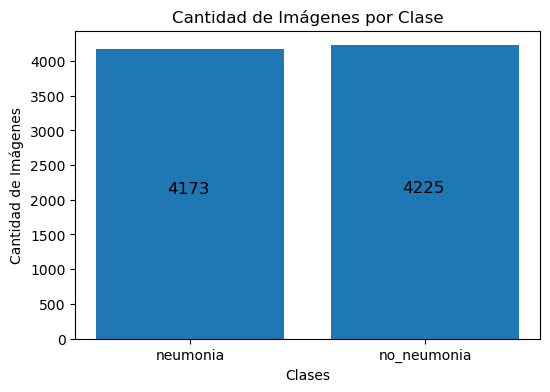

In [11]:
mostrar_grafico_clases(etiquetas_entrenamiento)

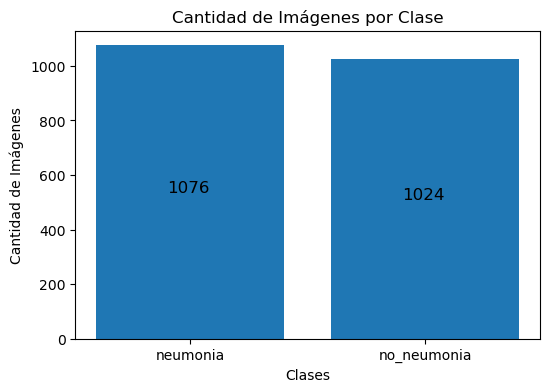

In [12]:
mostrar_grafico_clases(etiquetas_prueba)

In [13]:
imagenes_entrenamiento = np.array(imagenes_entrenamiento).astype(float) / 255
imagenes_prueba = np.array(imagenes_prueba).astype(float) / 255

etiquetas_entrenamiento = np.array(etiquetas_entrenamiento)
etiquetas_prueba = np.array(etiquetas_prueba)

forma_etiqueta = etiquetas_entrenamiento[0].shape #Esto muestra el formato actual de las etiquetas, en particular muestra la primera
                                                    #del array de entrenamiento
print(forma_etiqueta)

(2,)


In [14]:
print(etiquetas_entrenamiento.shape)

(8398, 2)


In [15]:
modelo_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    tf.keras.layers.MaxPooling2D(3, 3),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [16]:
modelo_cnn.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['categorical_accuracy'])

In [17]:
vueltas = 20

In [18]:
historial_cnn = modelo_cnn.fit(imagenes_entrenamiento, etiquetas_entrenamiento, epochs=vueltas, validation_data=(imagenes_prueba, etiquetas_prueba), use_multiprocessing=True, shuffle=True)

Epoch 1/20
263/263 [==============================] - 56s 210ms/step - loss: 0.3096 - categorical_accuracy: 0.8778 - val_loss: 0.1669 - val_categorical_accuracy: 0.9381
Epoch 2/20
263/263 [==============================] - 54s 205ms/step - loss: 0.1536 - categorical_accuracy: 0.9457 - val_loss: 0.1250 - val_categorical_accuracy: 0.9567
Epoch 3/20
263/263 [==============================] - 54s 206ms/step - loss: 0.1207 - categorical_accuracy: 0.9571 - val_loss: 0.1048 - val_categorical_accuracy: 0.9619
Epoch 4/20
263/263 [==============================] - 54s 205ms/step - loss: 0.0898 - categorical_accuracy: 0.9655 - val_loss: 0.0988 - val_categorical_accuracy: 0.9671
Epoch 5/20
263/263 [==============================] - 54s 205ms/step - loss: 0.0766 - categorical_accuracy: 0.9732 - val_loss: 0.0888 - val_categorical_accuracy: 0.9695
Epoch 6/20
263/263 [==============================] - 54s 204ms/step - loss: 0.0591 - categorical_accuracy: 0.9780 - val_loss: 0.0885 - val_categorical_acc

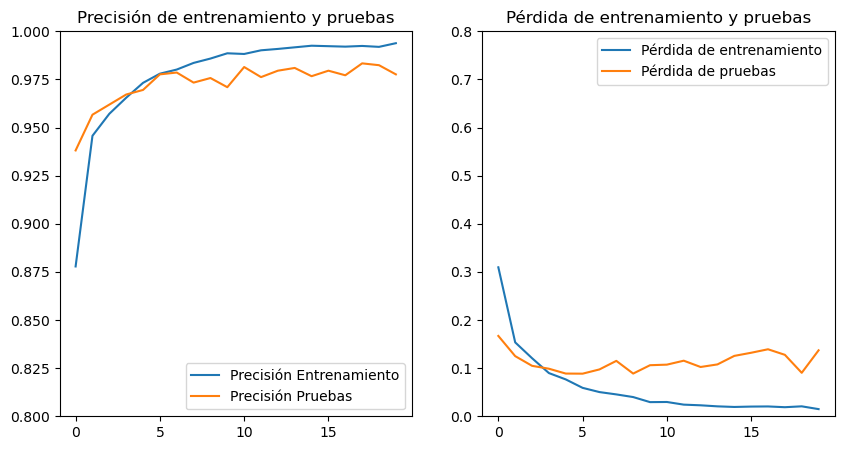

In [19]:
# Graficas de precisión y pérdida del modelo
categorical_accuracy = historial_cnn.history['categorical_accuracy']
val_categorical_accuracy = historial_cnn.history['val_categorical_accuracy']

loss = historial_cnn.history['loss']
val_loss = historial_cnn.history['val_loss']

rango_epocas = range(vueltas)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(rango_epocas, categorical_accuracy, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_categorical_accuracy, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.ylim(0.8, 1)
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label= 'Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.ylim(0, 0.8)
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [20]:
def es_correcta(prediccion, esperado):
    return prediccion.index(max(prediccion)) == esperado.index(max(esperado))

In [21]:
correctas_segun_tipo = [0, 0]
falladas_segun_tipo = [0, 0]

predicciones = modelo_cnn.predict(imagenes_prueba)
print(f"Cantidad de predicciones: {len(predicciones)}")

for i in range(len(predicciones)):
    prediccion = list(predicciones[i])
    index = prediccion.index(max(prediccion))

    if es_correcta(prediccion, list(etiquetas_prueba[i])):
        correctas_segun_tipo[index] += 1
    else:
        falladas_segun_tipo[index] += 1

cant_totales = list(map(lambda x, y: x + y, correctas_segun_tipo, falladas_segun_tipo))
print("Etiquetas:   [Neum, No_Neum]")
print(f"Total:       {cant_totales}")
print(f"Correctas:   {correctas_segun_tipo}")
print(f"Incorrectas: {falladas_segun_tipo}")

66/66 [==============================] - 4s 56ms/step
Cantidad de predicciones: 2100
Etiquetas:   [Neum, No_Neum]
Total:       [1047, 1053]
Correctas:   [1038, 1015]
Incorrectas: [9, 38]
